Importing

In [136]:
import torch
from torch.optim import Adam
from torch.optim import LBFGS
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import copy
import seaborn as sns
sns.set_style('darkgrid')

from scipy import integrate # numerical integration tool for ode's

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Physical System to Model: Spring, Mass, and Damper System

$ F(t) -c \frac{d\mathbf{x}}{d t}(t) - kx(t) = m\frac{d\mathbf{x^2}}{d t}(t)$

$\frac{d\mathbf{x^2}}{d t}(t) = ( F(t) -c \frac{d\mathbf{x}}{d t}(t) - kx(t) ) /m$

Text(0.5, 1.0, 'Numerical Solution to Spring, Mass, and Damper system')

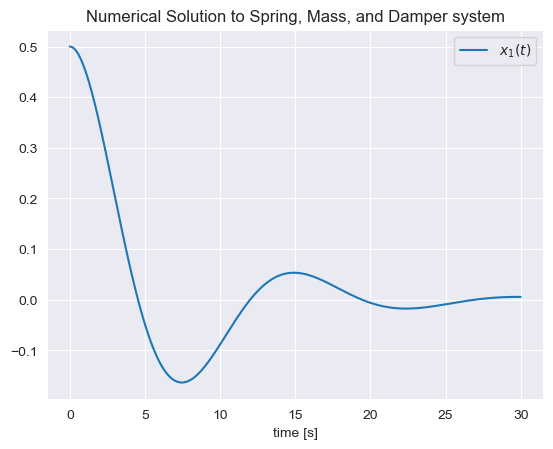

In [137]:
# Physical Parameters, c = damping constant, k =  stiffness of spring, m = mass.
p = dict(c=3, k=2, m=10, F=0, x0=0.5, dx0dt=0)
p['d2x0dt2'] = (p['F'] - p['c']*p['dx0dt'] - p['k']*p['x0']) / p['m']

#initial conditions
x0 = [p['x0'],p['dx0dt']]
#plot to time T
T = 30

def f(x,t,p):
    x1, x2 = x[0], x[1]
    dx1 = x2
    dx2 = (p['F'] - p['c']*x2 - p['k']*x1) / p['m']
    return([dx1,dx2])

#Function to solve the physical system using numerical integration tool
def run_oscil(x0,T,p):
    t = np.linspace(0, T, 1000)
    dxdt = lambda x,t : f(x, t, p)
    x_t = integrate.odeint(dxdt, x0, t)
    return(t,x_t)

#Plotting neumerical solution
t_plot, x_plot = run_oscil(x0,T,p)
sns.lineplot(x=t_plot,y=x_plot[:,0],label='$x_1(t)$')
#sns.lineplot(x=t_plot,y=x_plot[:,1],label='$x_2(t)$')
plt.xlabel('time [s]')
plt.title("Numerical Solution to Spring, Mass, and Damper system")

The equation that models the Spring, Mass, and Damper System is the following:
$ F(t) = m\frac{d\mathbf{x^2}}{d t}(t) + c \frac{d\mathbf{x}}{d t}(t) + kx(t)$

The following parameters are needed to fully define the system:
1. Sum of Forces (F)
2. Mass (m)
3. Damping Constant (c)
4. Spring Stiffness (k)
5. Time (t)
6. Initial Conditions (x0)

These parameters can be used to determine the position (x) at current time (t).

Comparing plots of MLP approximation against numerical solution.

In [138]:
def plot_comp(t):
    t_plot_comp, x_plot_comp = run_oscil(x0,t,p)
    plt.plot(t_plot_comp,x_plot_comp[:,0],label='Numerical Solution')
    plt.xlabel('time [s]')

    # obtaining plotting information
    # inputs: vector with cols 0:t, 1:F, 2:M, 3:c, 4:k, 5:x(0), 6:x'(0)

    #creating tensors to be plotted
    plot_tuple = tuple()

    plot_t = torch.from_numpy(t_plot_comp).float().view(-1,1)
    plot_tuple += (plot_t,)

    plot_input = torch.cat(plot_tuple, 1).requires_grad_(True)
    plot_input = plot_input.to(device)
    pred = model(plot_input)
    _, loss_absolute = loss_fn(model, plot_input)
    pred_plot = torch.reshape(pred, (-1,)).cpu().detach().numpy()
    loss_MSE = np.sum( (pred_plot - x_plot_comp[:,0])**2 )

    plt.title(f"Comparing MLP Approximation and Numerical Solution, Loss fn: {loss_absolute:.2E}, MSE Loss: {loss_MSE:.2E} Epoch {epoch}")
    plt.plot(t_plot_comp,pred_plot,label='MLP Approximation')

    plt.plot(sample_t, sample_x,"g.", label="Samples")

    plt.legend()
    plt.show()
    plt.clf()

Creating vectors for all parameters to be modelled

In [139]:
t = 30
train_tuple = tuple()
# Range of t to be modelled [0,30]S
t_train = torch.linspace(0,t,64).view(-1,1)
train_tuple += (t_train,)

train = torch.cat(train_tuple,1).requires_grad_(True)
train = train.to(device)

n_samples = 30
sample_t, sample_x = list(),list()
for n in range(n_samples):
    index = np.random.randint(0, len(t_plot))
    sample_t.append(t_plot[index])
    sample_x.append(x_plot[index,0])
samples = torch.t(torch.Tensor([sample_t,sample_x])).requires_grad_(True)
samples = samples.to(device)

Creating the Model

In [140]:
# i_num nodes, i_len nodes per layer and Tanh activation fn, wide and shallow (64x4)
i_num = 2
i_len = 64
#params to take and approximate
params_in = 1
params_out = 1

# fn to create model
def pinn(input_size, output_size, num_layers, nodes_per_layer, activation):
    layers = []
    
    # Input layer
    layers.append(nn.Linear(input_size, nodes_per_layer))
    
    # Hidden layers
    for layer in range(num_layers):
        layers.append(nn.Linear(nodes_per_layer, nodes_per_layer))
        if layer == 0 and activation==Siren:
            layers.append(activation(l=0))
        else:
            layers.append(activation())
    
    # Output layer
    layers.append(nn.Linear(nodes_per_layer, output_size))
    
    return nn.Sequential(*layers)

# custom trainable Tanh activation fn
class TTanh(nn.Module):
    def __init__(self, features=i_len):
        super().__init__()
        self.features = features
        self.a = nn.Parameter(torch.randn(1, features))
        
    def forward(self, x):
        return torch.tanh(self.a * x)

#custom SIREN activation fn
class Siren(nn.Module):
    def __init__(self, features=i_len, l=1):
        super(Siren, self).__init__()
        self.features = features
        # Learnable parameters for the phase and bias
        if l: w = 1 
        else: w = 30
        n = torch.sqrt(torch.tensor(6.0/features))
        self.a_weight = nn.Parameter((torch.rand(1, features) *2*n - n)*w)
        self.a_bias = nn.Parameter(torch.randn(1, features))

    def forward(self, x):
        # Apply the periodic activation function
        return torch.sin( self.a_weight*x + self.a_bias)

k_pred = nn.Parameter(torch.zeros(1).to(device), requires_grad=True)

model = pinn(params_in, params_out, i_num, i_len, Siren)
model.to(device)


Sequential(
  (0): Linear(in_features=1, out_features=64, bias=True)
  (1): Linear(in_features=64, out_features=64, bias=True)
  (2): Siren()
  (3): Linear(in_features=64, out_features=64, bias=True)
  (4): Siren()
  (5): Linear(in_features=64, out_features=1, bias=True)
)

Creating a custom loss function using the following:

Physics Loss:

$ F(t) - m\frac{d\mathbf{x^2}}{d t}(t) - c \frac{d\mathbf{x}}{d t}(t) - kx(t) = 0$

MSE Loss against samples

In [141]:
def loss_fn(model, batch):
    # model: model
    # batch: vector with cols 0:t, 1:F, 2:M, 3:c, 4:k, 5:x(0), 6:x'(0), 7:x''(0)

    # Obtaining parameters to compute phy loss.
    x_pred = model(batch)
    first_deriv = torch.autograd.grad(x_pred, batch, torch.ones_like(x_pred), create_graph=True, retain_graph=True)[0]
    second_deriv = torch.autograd.grad(first_deriv, batch, torch.ones_like(first_deriv), retain_graph=True)[0]

    dxdt_pred = first_deriv
    d2xdt2_pred = second_deriv

    F = p['F']
    m = p['m']
    c = p['c']

    #k is defined as paramter to be modelled

    # Calculate loss based on governing physics eqns
    phy_loss = torch.mean( (F - m*d2xdt2_pred - c*dxdt_pred - k_pred*x_pred)**2 )

    # Calulate loss from samples
    
    #obtaining initial conditions pred
    sample_pred = model(samples[:,0].view(-1,1))
    sample_loss = torch.sum( (sample_pred - samples[:,1].view(-1,1))**2 )

    # calculate weighted loss
    sample_loss_weighted = sample_loss*sample_weight

    loss_weighted = sample_loss_weighted + phy_loss
    loss_absolute = phy_loss + sample_loss

    optim.zero_grad()
    sample_loss_weighted.backward(retain_graph=True)
    temp = list()
    for name, param in model.named_parameters():
        if param.grad is not None:
            temp.append(torch.reshape(param.grad,(-1,)))
    sample_grads.append(torch.cat(temp))

    optim.zero_grad()
    phy_loss.backward(retain_graph=True)
    temp = list()
    for name, param in model.named_parameters():
        if param.grad is not None:
            temp.append(torch.reshape(param.grad,(-1,)))
    phy_grads.append(torch.cat(temp))

    return (loss_weighted, loss_absolute)

Loss weights are dynamically updated using:

$\hat{\lambda}^{(n)}_{ic} = \frac{max \{| {\nabla_{\theta}} \mathcal{L}_{physics} |\} } {| \overline{ {\nabla_{\theta}} \mathcal{L}_{ic} } |} $
or
$ \frac{std \{ {\nabla_{\theta}} \mathcal{L}_{physics} \} } {std \{ {\nabla_{\theta}} \mathcal{L}_{ic} \} } $
or
$\frac{|| {\nabla_{\theta}} \mathcal{L}_{physics} ||_{2} } {|| {\nabla_{\theta}} \mathcal{L}_{ic} ||_{2} } $

$\lambda^{(n)}_{ic} = \alpha \lambda^{(n-1)}_{ic} + (1 - \alpha) \hat{\lambda}^{(n)}_{ic}  $

In [142]:
phy_grads, sample_grads = list(), list()
sample_weight = 1.0

def weight_update_max_mean(w_update, a=0.9):
    phy_loss_max = torch.max(torch.abs(torch.stack(phy_grads[-w_update:])))
    sample_loss_mean = torch.mean(torch.abs(torch.stack(sample_grads[-w_update:])))
    ic_weight_hat = (phy_loss_max / sample_loss_mean).item()
    new_ic_weight = (1-a)*sample_weight + a*ic_weight_hat
    return new_ic_weight

def weight_update_std(w_update, a=0.9):
    phy_loss_std = torch.std(torch.stack(phy_grads[-w_update:]))
    sample_loss_std = torch.std(torch.stack(sample_grads[-w_update:]))
    ic_weight_hat = (phy_loss_std / sample_loss_std).item()
    new_ic_weight = (1-a)*sample_weight + a*ic_weight_hat
    return new_ic_weight

def weight_update_norm(w_update, a=0.9):
    phy_loss_norm = torch.linalg.matrix_norm(torch.stack(phy_grads[-w_update:]))
    sample_loss_norm = torch.linalg.matrix_norm(torch.stack(sample_grads[-w_update:]))
    ic_weight_hat = (phy_loss_norm / sample_loss_norm).item()
    new_ic_weight = (1-a)*sample_weight + a*ic_weight_hat
    return new_ic_weight

Checkpoint During Training

In [143]:
best_model_adam = {'epoch':-1}

def checkpoint(best_model):
    if (best_model['epoch'] == -1) or (prev_loss[-1] < best_model['loss']):
        best_model = {
            'epoch': epoch,
            'model_state_dict': copy.deepcopy(copy.deepcopy(model.state_dict())),
            'optimizer_state_dict': copy.deepcopy(copy.deepcopy(optim.state_dict())),
            'loss': prev_loss[-1],
                    }
    return best_model

Plot Training Data

In [144]:
def plot_train(n=0):
    plt.plot(np.log10(prev_loss[n:]),c='tab:blue',label='Log Loss')
    plt.title(f"Log Loss over {len(prev_loss[n:])} Calls")
    plt.xlabel("Calls")
    plt.ylabel("Log Loss")
    plt.show()
    plt.clf()

    plt.plot(torch.log10(torch.mean(torch.abs(torch.stack(phy_grads[n:],1)),0)).cpu(),label='log mean phy loss grad',c='tab:green')
    plt.title(f"Gradient of parameters wrt Physics Loss over {len(prev_loss[n:])} Calls")
    plt.xlabel("Loss Computations")
    plt.ylabel("Log Mean gradients for model parameters")
    plt.legend()
    plt.show()
    plt.clf()

    plt.plot(torch.log10(torch.mean(torch.abs(torch.stack(sample_grads[n:],1)),0)).cpu(),label='log mean ic loss grad',c='tab:orange')
    plt.title(f"Gradient of parameters wrt Samples Loss over {len(prev_loss[n:])} Calls")
    plt.xlabel("Loss Computations")
    plt.ylabel("Log Mean gradients for model parameters")
    plt.legend()
    plt.show()
    plt.clf()

    plt.plot(prev_k,label='k eatimate',c='tab:blue')
    plt.title(f"Estimation of k over Loss Computations")
    plt.xlabel("Loss Computations")
    plt.ylabel("Estimation of k")
    plt.legend()
    plt.show()
    plt.clf()

Closure Fn for Optimisers

In [145]:
def closure():
    loss_weighted, loss_absolute = loss_fn(model, train)
    optim.zero_grad()
    loss_weighted.backward()
    prev_loss.append(loss_absolute.item())
    prev_k.append(k_pred.item())
    return loss_weighted

Training with Adam

Finished epoch 0, latest loss 2.03E+01
Finished epoch 1000, latest loss 9.83E-02
Finished epoch 2000, latest loss 4.54E-02
Finished epoch 3000, latest loss 1.62E-02
Finished epoch 4000, latest loss 1.91E-03
Finished epoch 5000, latest loss 1.80E-02
Finished epoch 6000, latest loss 2.37E-03
Finished epoch 7000, latest loss 9.08E-03
Finished epoch 8000, latest loss 9.28E-03
Finished epoch 9000, latest loss 1.24E-02
Finished epoch 10000, latest loss 2.08E-03


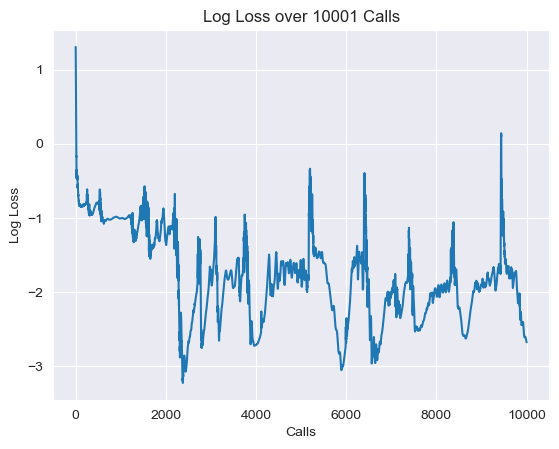

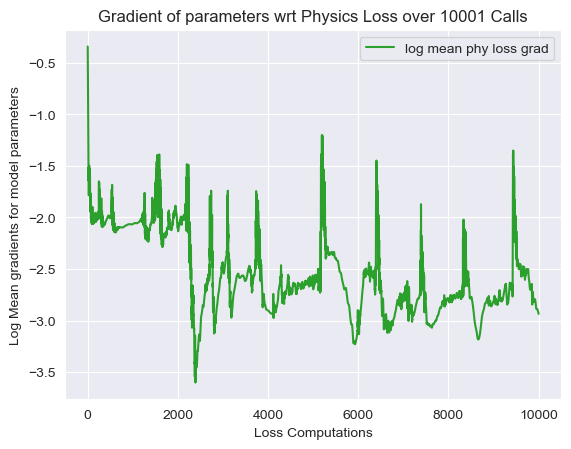

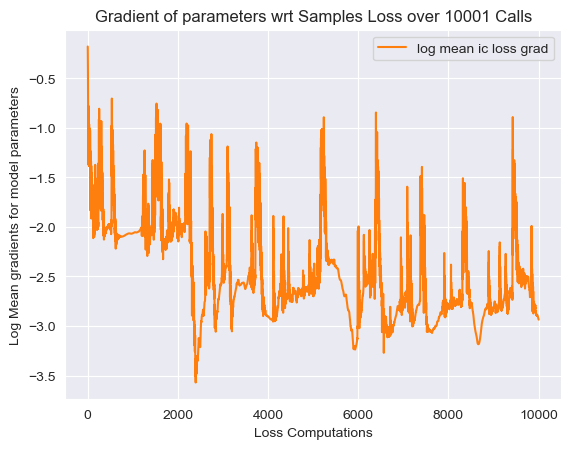

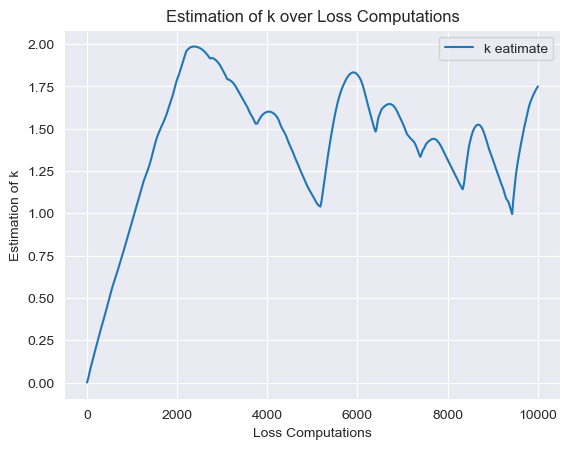

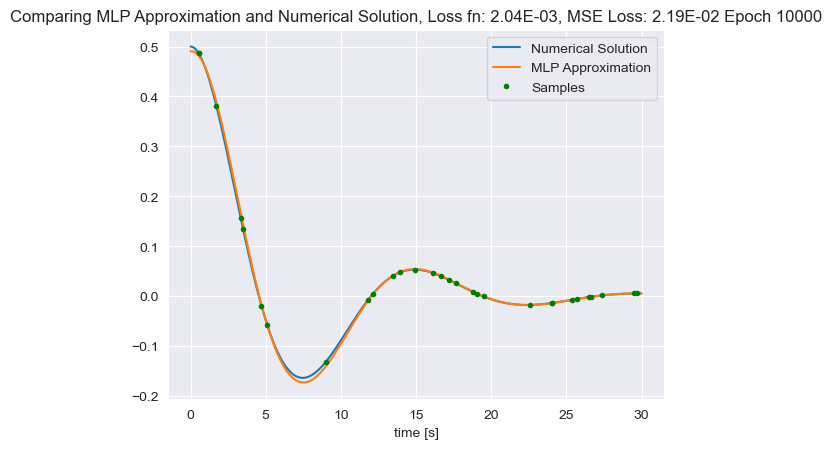

1.7500245571136475


<Figure size 640x480 with 0 Axes>

In [146]:
# train
n_epochs = 10001
w_update = 1
# start with Adam optimizer
optim = Adam(list(model.parameters())+[k_pred],lr=1e-3)
prev_loss = list()
prev_k = list()

for epoch in range(n_epochs):
    
    optim.step(closure)
    best_model_adam = checkpoint(best_model_adam)

    if not (epoch%w_update): ic_weight = weight_update_max_mean(w_update)
    if not (epoch%1000): print(f'Finished epoch {epoch}, latest loss {prev_loss[-1]:.2E}')

# plot for Adam optimization stage
plot_train()
plot_comp(t)
print(k_pred.item())

Plot Best Model trainined with Adam

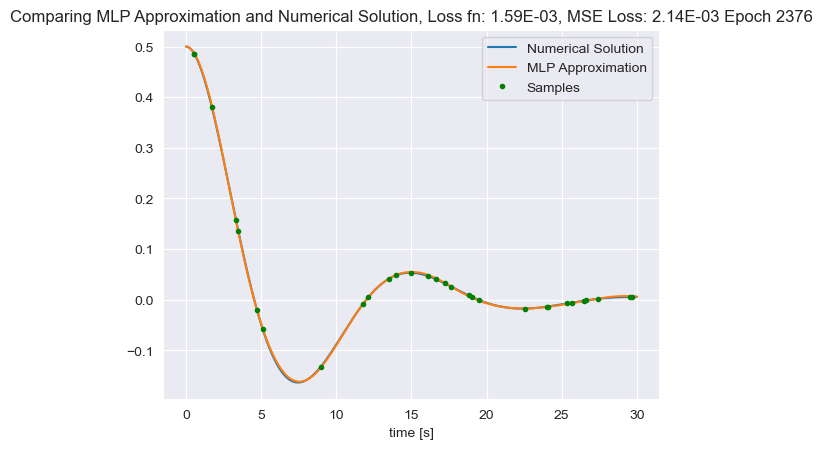

1.9854214191436768


<Figure size 640x480 with 0 Axes>

In [147]:

model.load_state_dict(best_model_adam['model_state_dict'])
optim.load_state_dict(best_model_adam['optimizer_state_dict'])
epoch = best_model_adam['epoch']
loss = best_model_adam['loss']
k_pred_best = prev_k[epoch]

model.eval()


plot_comp(t)
print(k_pred_best)

Saving Best Model

In [148]:
'''
model.load_state_dict(best_model['model_state_dict'])
optim.load_state_dict(best_model['optimizer_state_dict'])
epoch = best_model['epoch']
loss = best_model['loss']

PATH = f"Models\\{loss:.2E}_{epoch}.tar"
torch.save(best_model, PATH)
'''

'\nmodel.load_state_dict(best_model[\'model_state_dict\'])\noptim.load_state_dict(best_model[\'optimizer_state_dict\'])\nepoch = best_model[\'epoch\']\nloss = best_model[\'loss\']\n\nPATH = f"Models\\{loss:.2E}_{epoch}.tar"\ntorch.save(best_model, PATH)\n'

Load Model

In [149]:
'''
PATH = "Models\\"

#checkpoint = torch.load(PATH, map_location=device)
#model.load_state_dict(checkpoint['model_state_dict'])
#optim.load_state_dict(checkpoint['optimizer_state_dict'])
#epoch = checkpoint['epoch']
#loss = checkpoint['loss']

#model.eval()
# - or -
#model.train()

#plot_comp()
'''

'\nPATH = "Models\\"\n\n#checkpoint = torch.load(PATH, map_location=device)\n#model.load_state_dict(checkpoint[\'model_state_dict\'])\n#optim.load_state_dict(checkpoint[\'optimizer_state_dict\'])\n#epoch = checkpoint[\'epoch\']\n#loss = checkpoint[\'loss\']\n\n#model.eval()\n# - or -\n#model.train()\n\n#plot_comp()\n'